# Scenario Analysis for the possible wolf habitats

**Author:** Florian Klaver

This notebook derives two distinct "Proposed Habitat Zones" based on the Habitat Suitability Index (HSI) and Conflict layers. It compares the biological potential against a socially acceptable core area.

**Scenarios:**  
1. "Best Case Wolf" (Ecological Potential):
   - Criteria: HSI >= 0.60.
   - Logic: Maximum biological potential, ignoring administrative boundaries or conflicts.
2. "Best Case Human" (Conflict-Minimized Core):
   - Criteria: HSI >= 0.60 AND No Conflict AND Strict Safety Buffers.
   - Logic: Wolf habitat restricted to areas where conflicts with agriculture (livestock) 
     and humans (settlements) are minimized.

**Processing:**  
- Applies thresholds and masks.
- "Despeckling": Removes small isolated patches (< 10 ha) to reduce noise.
- Calculates area statistics (km²) and habitat loss.

**Output:**  
- scenario_best_case_wolf.tif (Binary 1/0)
- scenario_best_case_human.tif (Binary 1/0)



## Setup

In [17]:
import os
import geopandas as gpd
import rasterio
from rasterio import features
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from pathlib import Path
from scipy.ndimage import label

In [18]:
# --- CONFIGURATION ---
try:
    # Try to get the script directory (works for standard .py files)
    script_dir = Path(__file__).parent
except NameError:
    # Fallback for Jupyter Notebooks
    script_dir = Path.cwd()

PROJECT_ROOT = script_dir.parent
DATA_DIR = PROJECT_ROOT / 'data'
OUTPUT_DIR = PROJECT_ROOT / 'output'

# Input Files
PATHS = {
    "habitat": OUTPUT_DIR / "habitat_suitability_final_wlc.tif", 
    "conflict": OUTPUT_DIR / "conflict_zones_filtered.tif",        
    "water": OUTPUT_DIR / "water_mask_10m.tif",
    "boundaries": DATA_DIR / "swissBOUNDARIES3D_1_5_LV95_LN02.gpkg",
    # Raw distances for strict safety filtering in Human Scenario
    "dist_roads": OUTPUT_DIR / "distance_roads_10m.tif",
    "dist_settle": OUTPUT_DIR / "distance_settlements_10m.tif"

}

# Output Files
OUT_WOLF = OUTPUT_DIR / "scenario_best_case_wolf.tif"
OUT_HUMAN = OUTPUT_DIR / "scenario_best_case_human.tif"

# --- PARAMETERS ---
THRESHOLDS = {
    "min_hsi": 0.60,           # Minimum Habitat Score to be considered "Suitable"
    "min_area_pixels": 1000,   # Minimum Patch Size (1000 pixels = 10 Hectares)
    
    # STRICT SAFETY BUFFERS (Only applied to Human Scenario)
    # Even if HSI is good (e.g. dense forest), we exclude areas too close to humans/roads.
    "human_safe_dist_settle": 750, # meters
    "human_safe_dist_road": 250    # meters
}

## Process

In [19]:
# --- FUNCTIONS ---

def read_raster(path):
    """Reads a raster file."""
    with rasterio.open(path) as src:
        return src.read(1), src.profile, src.nodata
    
def get_graubuenden_boundary():
    """Loads the exact vector boundary of Graubünden."""
    print("      -> Loading Cantonal Boundary for clipping...")
    try:
        gdf = gpd.read_file(PATHS["boundaries"], layer='TLM_KANTONSGEBIET')
        
        if 'NAME' in gdf.columns:
            gdf_gr = gdf[gdf['NAME'].isin(['Graubünden', 'Grigioni', 'Grischun'])]
        elif 'name' in gdf.columns:
            gdf_gr = gdf[gdf['name'].isin(['Graubünden', 'Grigioni', 'Grischun'])]
        elif 'kantonsnummer' in gdf.columns:
            gdf_gr = gdf[gdf['kantonsnummer'] == 18]
        else:
            return None

        try:
            return gdf_gr.geometry.union_all()
        except AttributeError:
            return gdf_gr.geometry.unary_union
    except Exception as e:
        print(f"Error loading boundaries: {e}")
        return None    

def filter_small_patches(binary_mask, min_size):
    """
    Removes connected components smaller than min_size pixels.
    Uses Connected Component Labeling to identify and filter patches.
    """
    print(f"      -> Filtering patches < {min_size} pixels...")
    
    # 8-connectivity structure (diagonal pixels count as connected)
    structure = np.ones((3, 3), dtype=int)
    
    # Label connected components
    labeled, n_components = label(binary_mask, structure)
    
    # Count pixels per label
    sizes = np.bincount(labeled.ravel())
    
    # Create mask of allowed labels
    mask_sizes = sizes >= min_size
    mask_sizes[0] = 0 # Ensure background (0) remains background
    
    # Map back to image dimensions
    return mask_sizes[labeled].astype(np.uint8)

In [20]:
# ==========================================
# MAIN EXECUTION
# ==========================================

print("\n" + "="*40)
print("STARTING SCENARIO ANALYSIS")
print("="*40)

# --- 1. LOAD DATA ---
print("1. Loading Layers...")
if not PATHS["habitat"].exists():
    print("CRITICAL ERROR: Habitat layer missing. Run previous analysis scripts first.")
    exit()

hsi, profile, nodata_hsi = read_raster(PATHS["habitat"])
conflict, _, _ = read_raster(PATHS["conflict"]) 
water, _, _ = read_raster(PATHS["water"])
d_road, _, _ = read_raster(PATHS["dist_roads"])
d_settle, _, _ = read_raster(PATHS["dist_settle"])

# Create a binary raster mask from the vector boundary to clip exactly to the canton
print("   -> Creating Exact Boundary Mask...")
gr_geom = get_graubuenden_boundary()
if gr_geom is not None:
    # Rasterize the vector geometry to match the HSI grid
    with rasterio.open(PATHS["habitat"]) as src:
        boundary_mask = features.rasterize(
            [(gr_geom, 1)],
            out_shape=src.shape,
            transform=src.transform,
            fill=0,
            default_value=1,
            dtype=rasterio.uint8
        )
else:
    print("Warning: Could not load boundary vector. Area calculation might include buffer zones.")
    boundary_mask = np.ones(hsi.shape, dtype=np.uint8)

# Apply Boundary Mask to NoData Logic
# Valid = (HSI exists) AND (Inside Canton Polygon)
valid_mask = (hsi != nodata_hsi) & (boundary_mask == 1)
hsi_clean = np.where(valid_mask, hsi, 0)

# Calculate Total Study Area
total_pixels = np.sum(valid_mask)
total_area_km2 = total_pixels * 100 / 1_000_000 # 10m resolution = 100m² per pixel
print(f"   -> Total Study Area (Graubünden): {total_area_km2:.2f} km²")


# --- 2. CALCULATE SCENARIO 1: BEST CASE WOLF ---
print(f"2. Calculating 'Best Case Wolf' (HSI >= {THRESHOLDS['min_hsi']})...")

# Logic: Purely Biological.
# - Must meet minimum suitability score.
# - Must not be water.
mask_wolf_raw = (hsi_clean >= THRESHOLDS["min_hsi"]) & (water == 0)

# Filter Noise (Despeckling)
mask_wolf = filter_small_patches(mask_wolf_raw, THRESHOLDS["min_area_pixels"])

# Calculate Statistics
pixels_wolf = np.sum(mask_wolf)
area_wolf_km2 = pixels_wolf * 100 / 1_000_000 # 100m² per pixel
print(f"   -> Total Wolf Habitat Area: {area_wolf_km2:.2f} km²")


# --- 3. CALCULATE SCENARIO 2: BEST CASE HUMAN ---
print(f"3. Calculating 'Best Case Human' (Conflict-Free + Safety Zones)...")

# Logic: Social Acceptance.
# - Must meet minimum suitability score.
# - NO Conflict zones (No livestock overlap).
# - Strict safety buffers around settlements and roads.
# - Not water.

# Create Safety Mask based on raw distances
safety_mask = (d_settle >= THRESHOLDS["human_safe_dist_settle"]) & \
              (d_road >= THRESHOLDS["human_safe_dist_road"])

mask_human_raw = (
    (hsi_clean >= THRESHOLDS["min_hsi"]) & 
    (conflict == 0) &                            
    (water == 0) &
    (safety_mask) 
)

# Filter Noise
mask_human = filter_small_patches(mask_human_raw, THRESHOLDS["min_area_pixels"])

# Calculate Statistics
pixels_human = np.sum(mask_human)
area_human_km2 = pixels_human * 100 / 1_000_000
print(f"   -> Human-Compatible Area: {area_human_km2:.2f} km²")

# Comparison
loss_pct = (1 - (pixels_human / pixels_wolf)) * 100 if pixels_wolf > 0 else 0
print(f"\n HABITAT LOSS due to Human Constraints: {loss_pct:.1f}%")


STARTING SCENARIO ANALYSIS
1. Loading Layers...
   -> Creating Exact Boundary Mask...
      -> Loading Cantonal Boundary for clipping...
   -> Total Study Area (Graubünden): 7072.43 km²
2. Calculating 'Best Case Wolf' (HSI >= 0.6)...
      -> Filtering patches < 1000 pixels...
   -> Total Wolf Habitat Area: 2654.87 km²
3. Calculating 'Best Case Human' (Conflict-Free + Safety Zones)...
      -> Filtering patches < 1000 pixels...
   -> Human-Compatible Area: 659.59 km²

 HABITAT LOSS due to Human Constraints: 75.2%


4. Exporting Scenarios...
 Success! Saved Wolf Scenario: c:\Workspace\ZHAW\5. Semester\GIS\Wolf_habitat_suitability_Graubunden\output\scenario_best_case_wolf.tif
 Success! Saved Human Scenario: c:\Workspace\ZHAW\5. Semester\GIS\Wolf_habitat_suitability_Graubunden\output\scenario_best_case_human.tif
5. Generating Comparison Plot...


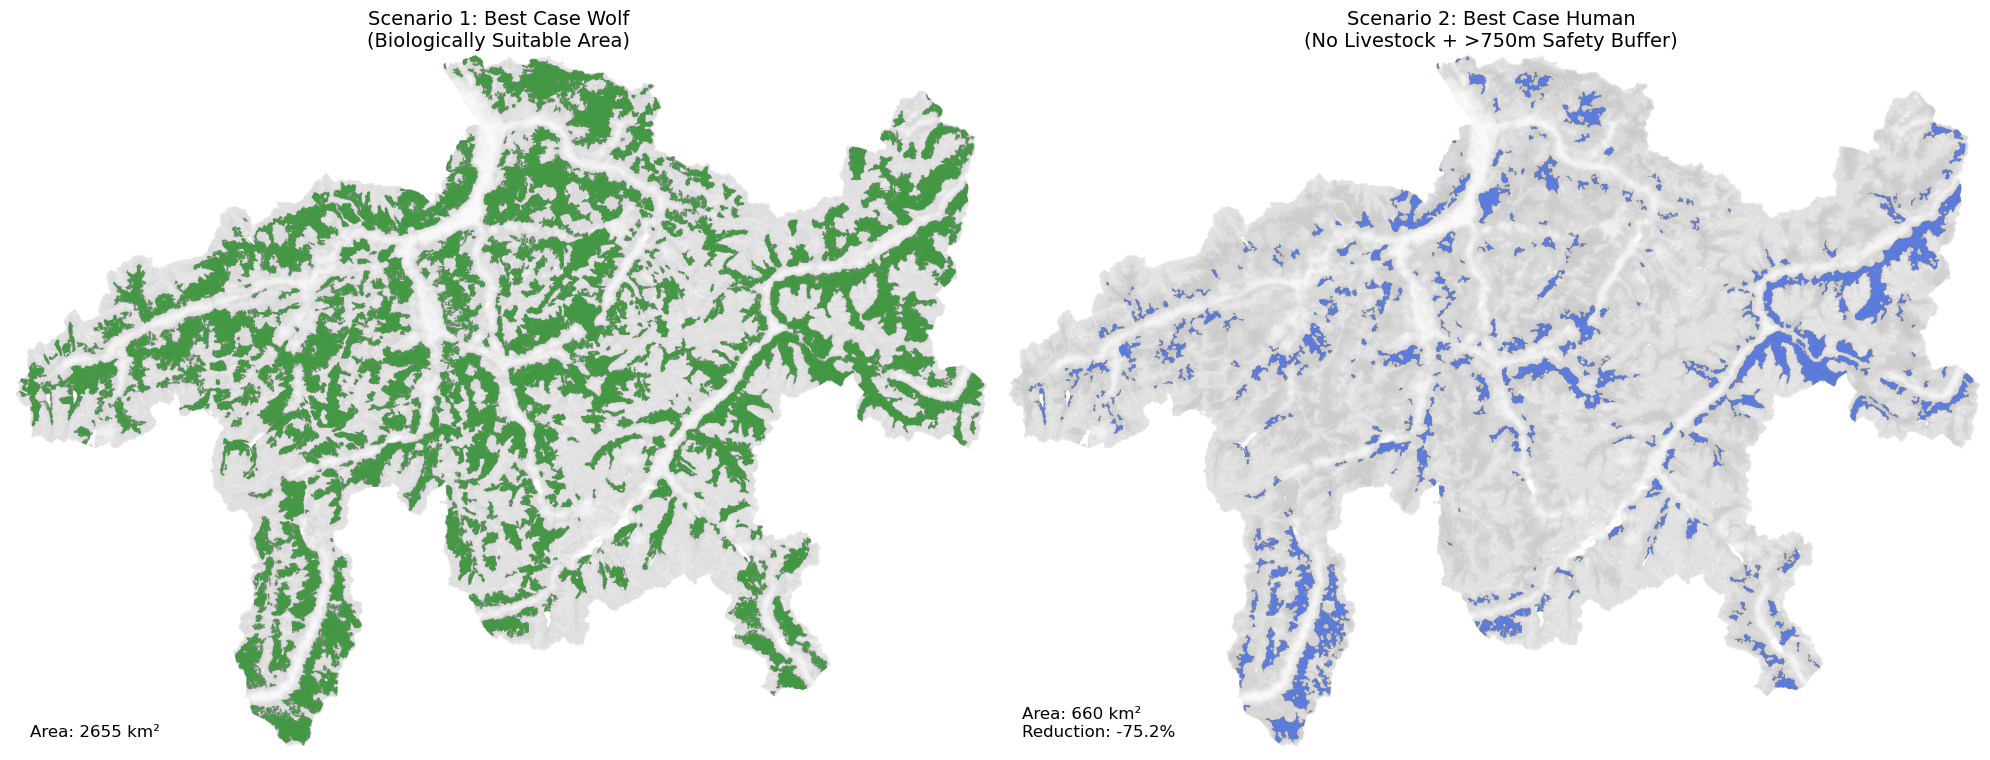

In [21]:
# --- 4. EXPORT ---
print("4. Exporting Scenarios...")
profile.update(dtype=rasterio.uint8, count=1, nodata=0)

with rasterio.open(OUT_WOLF, 'w', **profile) as dst:
    dst.write(mask_wolf, 1)
print(f" Success! Saved Wolf Scenario: {OUT_WOLF}")

with rasterio.open(OUT_HUMAN, 'w', **profile) as dst:
    dst.write(mask_human, 1)
print(f" Success! Saved Human Scenario: {OUT_HUMAN}")


# --- 5. VISUALIZATION ---
print("5. Generating Comparison Plot...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

def plot_backdrop(ax, title):
    """Helper to plot the grey background (simplified HSI)"""
    ax.imshow(hsi_clean, cmap='Greys', vmin=0, vmax=1, alpha=0.3)
    ax.set_title(title, fontsize=14)
    ax.axis('off')

# Plot Wolf Scenario
plot_backdrop(ax1, f"Scenario 1: Best Case Wolf\n(Biologically Suitable Area)")
wolf_plot = np.ma.masked_where(mask_wolf == 0, mask_wolf)
ax1.imshow(wolf_plot, cmap=ListedColormap(['#228B22']), alpha=0.8) # Forest Green
# Add Stat Box
ax1.text(0.02, 0.02, f"Area: {area_wolf_km2:.0f} km²", transform=ax1.transAxes, 
         fontsize=12, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# Plot Human Scenario
plot_backdrop(ax2, f"Scenario 2: Best Case Human\n(No Livestock + >{THRESHOLDS['human_safe_dist_settle']}m Safety Buffer)")
human_plot = np.ma.masked_where(mask_human == 0, mask_human)
ax2.imshow(human_plot, cmap=ListedColormap(['#4169E1']), alpha=0.8) # Royal Blue
# Add Stat Box
ax2.text(0.02, 0.02, f"Area: {area_human_km2:.0f} km²\nReduction: -{loss_pct:.1f}%", transform=ax2.transAxes, 
         fontsize=12, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

plt.tight_layout()
plt.show()